In [142]:
import numpy as np
from scipy.integrate import quad_vec

In [143]:
def yuki(
    k,
    obj_func,
    args,
    learning_rate = 0.1,
    tolerance = 1e-6,
    iterations = 20
):
    for i in range(iterations):
        _, compliance = obj_func(k=k)

        k_new = k - learning_rate * compliance
        k_new = np.clip(k_new, 0.01, 1)

        if np.linalg.norm(k_new - k) < tolerance:
            break
        else:
            k = k_new

        print(f"It: {i}")

    return k, compliance

In [147]:
# MASTO

def nodal_heat_load(
    t: np.float64, # nodal temperature
    k: np.matrix # heat conductivity matrix
):
    return t * k


def heat_potential_capcity(
    q: np.matrix, # nodal heat load
    t: np.float64 # nodal temperature
):
    return q.T * t


def conductivity_matrix_node(
    x: np.float64,
    # y: np.float64,
    k: np.float64, # Thermal conductivity
    b: np.matrix # Differential of the shape function
):
    # return k * np.dot(b.T, b)
    return k * b.T * b


def conductivity_matrix(
    ne: np.float64, # Total number of elements
    k: np.float64, # Thermal conductivity
    b: np.matrix, # Differential of the shape function
    x_l: np.float64,
    x_u: np.float64,
    dm = 3
):
    b_shape = b.shape[0]
    kc = np.zeros([b_shape] * dm)
    # for n in range(ne):
    res, _ = quad_vec(conductivity_matrix_node, x_l, x_u, args=(k, b))
    kc += res

    return kc


def convection_matrix_node(
    x: np.float64,
    # y: np.float64,
    rho: np.float64, # Density
    cp: np.float64, # Specific heat capacity
    u_e: np.float64, # Element flow velocity from Darcy’s Law
    n_t: np.matrix, # Enhanced shape function
    b: np.matrix # Differential of the shape function
):
    # return rho * cp * np.dot(n_t.T, b) * u_e
    return rho * cp * n_t.T * b * u_e


def convection_matrix(
    ne: np.float64, # Total number of elements
    rho: np.float64, # Density
    cp: np.float64, # Specific heat capacity
    u_e: np.float64, # Element flow velocity from Darcy’s Law
    n_t: np.matrix, # Enhanced shape function
    b: np.matrix, # Differential of the shape function
    x_l: np.float64,
    x_u: np.float64,
    dm = 3
):  
    n_t_shape = n_t.shape[1]
    cpm = np.zeros([n_t_shape] * dm)
    # for n in range(ne):
    res, _ = quad_vec(convection_matrix_node, x_l, x_u, args=(rho, cp, u_e, n_t, b))
    cpm += res

    return cpm


# q_dot
def heat_load_derivative(
    k_dot: np.matrix,
    k: np.matrix,
    t_dot: np.matrix,
    t: np.matrix
):
    # return np.dot(k_dot, t) + np.dot(k, t_dot)
    return k_dot * t + k * t_dot


def general_compliance_sensitivity(
    t: np.matrix,
    k_dot: np.matrix
):
    # return -np.dot(t.T, np.dot(k_dot, t))
    return -t.T * k_dot * t


# EMI


# Sij
def notable_emphasis(
    e: np.matrix, # electric filed
    ka: np.matrix, # global antenna finite-element
):
    # return 0.5 * np.dot(e.T, np.dot(ka, e))
    return 0.5 * e.T * ka * e


def voltage_standing_wave_ratio(
    s00: np.float64
):
    s_abs = np.abs(s00)
    return (1 + s_abs) / (1 - s_abs)


def obj_func(
    c: np.float64,
    vswr: np.float64
):
    return c / vswr

In [148]:
class MASTO:
    def __init__(self, ne, t, rho, cp, u_e, b, e, ka, x_l, x_u, dm=3):
        self.ne = ne
        self.t = t
        self.rho = rho
        self.cp = cp
        self.u_e = u_e
        self.b = b
        self.e = e
        self.ka = ka
        self.x_l = x_l
        self.x_u = x_u
        self.dm = dm


    def __call__(self, k, *args, **kwds):
        # Обчислюємо теплову та конвекційну матриці
        kc = conductivity_matrix(self.ne, k, self.b, self.x_l, self.x_u, self.dm)
        # cpm = convection_matrix(num_elements, rho, cp, u_e, b, b, x_l, x_u)

        # Обчислення поточного значення цільової функції (наприклад, загальне навантаження)
        q = nodal_heat_load(self.t, kc)
        compliance = heat_potential_capcity(q, self.t)

        # Обчислюємо чутливість для поточного стану
        compliance_sensitivity = general_compliance_sensitivity(self.t, conductivity_matrix_node(1, k, self.b)).flatten()
        # compliance_sensitivity = np.array([
        #     general_compliance_sensitivity(t, conductivity_matrix_node(x, k_elem, b))
        #     for x, k_elem in enumerate(k)
        # ]).flatten()

        emi_value = notable_emphasis(self.e, self.ka)
        vswr = voltage_standing_wave_ratio(emi_value)
        emi = obj_func(compliance, vswr)

        return kc, compliance_sensitivity.reshape([self.ne] * self.dm) + emi

In [150]:
import numpy as np

# Кількість елементів
ne = 50  # Наприклад, 10 елементів

# Тестові значення параметрів для моделі
t = np.float64(300 + np.random.rand(ne, ne) * 50)  # Температура вузлів, 300 К
rho = np.float64(2700)  # Щільність матеріалу, кг/м^3 (алюміній)
cp = np.float64(900)  # Питома теплоємність, Дж/(кг·К)
u_e = np.float64(0.01 + np.random.rand(ne, ne) * 0.05)  # Швидкість потоку від закону Дарсі, м/с

# Матричні значення для тестування
b = np.random.rand(ne, ne, ne)  # Матриця диференціалів функції форми
# e = np.random.rand(ne, ne, ne)  # Матриця електричних полів
ka = np.random.rand(ne, ne, ne)  # Глобальна антена (EMI) матриця
e = np.zeros((ne, ne, ne))

prep_i = 0
for i in range(ne):
    ka[0:i, prep_i:i, 0:i] = np.random.rand(ne, ne, ne)[0:i, prep_i:i, 0:i]
    e[0:i, prep_i:i, 0:i] = np.random.rand(ne, ne, ne)[0:i, prep_i:i, 0:i]
    prep_i = i

x_l = np.float64(0)  # Нижня межа для інтеграції
x_u = np.float64(1)  # Верхня межа для інтеграції

# Початковий стан теплопровідності k
k = np.random.rand(ne, ne)  # Рандомні початкові значення для кожного елемента

# Створюємо об'єкт MASTO з тестовими даними
masto_model = MASTO(ne, t, rho, cp, u_e, b, e, ka, x_l, x_u)

# Функція оптимізації YUKI з цільовою функцією з MASTO
k_optimized, final_compliance = yuki(k, masto_model, {}, learning_rate=0.01, iterations=200)


It: 0
It: 1
It: 2
It: 3
It: 4
It: 5
It: 6
It: 7
It: 8
It: 9
It: 10
It: 11
It: 12
It: 13
It: 14
It: 15
It: 16
It: 17
It: 18
It: 19
It: 20
It: 21
It: 22
It: 23
It: 24
It: 25
It: 26
It: 27
It: 28
It: 29
It: 30
It: 31
It: 32
It: 33
It: 34
It: 35
It: 36
It: 37
It: 38
It: 39
It: 40
It: 41
It: 42
It: 43
It: 44
It: 45
It: 46
It: 47
It: 48
It: 49
It: 50
It: 51
It: 52
It: 53
It: 54
It: 55
It: 56
It: 57
It: 58
It: 59
It: 60
It: 61
It: 62
It: 63
It: 64
It: 65
It: 66
It: 67
It: 68
It: 69
It: 70
It: 71
It: 72
It: 73
It: 74
It: 75
It: 76
It: 77
It: 78
It: 79
It: 80
It: 81
It: 82
It: 83
It: 84
It: 85
It: 86
It: 87
It: 88
It: 89
It: 90
It: 91
It: 92
It: 93
It: 94
It: 95
It: 96
It: 97
It: 98
It: 99
It: 100
It: 101
It: 102
It: 103
It: 104
It: 105
It: 106
It: 107
It: 108
It: 109
It: 110
It: 111
It: 112
It: 113
It: 114
It: 115
It: 116
It: 117
It: 118
It: 119
It: 120
It: 121
It: 122
It: 123
It: 124
It: 125
It: 126
It: 127
It: 128
It: 129
It: 130
It: 131
It: 132
It: 133
It: 134
It: 135
It: 136
It: 137
It: 13

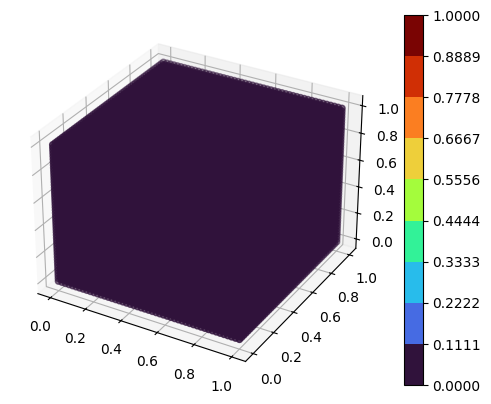

In [ ]:
import matplotlib.pyplot as plt
from matplotlib.colors import BoundaryNorm
from mpl_toolkits.mplot3d import Axes3D

c = np.tile(final_compliance.ravel()[:, None], [1, 3])

vKc = final_compliance.copy() / 1e+7
vKc[vKc > 0.1] = np.nan

nx, ny, nz = (ne, ne, ne)
x = np.linspace(0, 1, nx)
y = np.linspace(0, 1, ny)
z = np.linspace(0, 1, nz)
xv, yv, zv = np.meshgrid(x, y,z)

bounds = np.linspace(0, 1, 10)
norm = BoundaryNorm(bounds, len(bounds) - 1)
cmap = plt.get_cmap('turbo', len(bounds) - 1)

fig = plt.figure()
ax = fig.add_subplot(1, 1, 1, projection='3d')
scat = ax.scatter(xv, yv, zv, c=vKc, marker='o', cmap=cmap, norm=norm)
cbar = plt.colorbar(scat, ax=ax, ticks=bounds, format='%.4f')
plt.show()

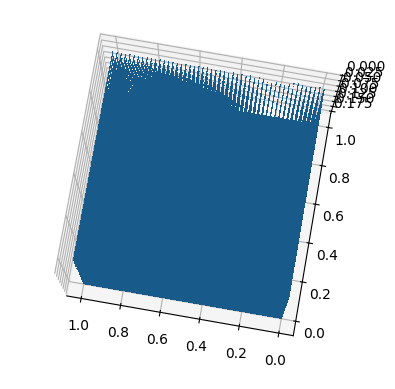

In [139]:
xvv = np.concat([xv[:, :, i] for i in range(10)])
yvv = np.concat([yv[:, :, i] for i in range(10)])
zvv = np.concat([zv[:, :, i] for i in range(10)])

fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
ax.plot_surface(xvv, yvv, zvv, linewidth=0, antialiased=False)
ax.view_init(azim=80, elev=-100)
plt.show()

In [140]:
with open("result.obj", 'w') as f:
    vertex_map = {}
    current_vertex_index = 1
    
    for i in range(xv.shape[0]):
        for j in range(xv.shape[1]):
            for k in range(xv.shape[2]):
                if not np.isnan(vKc[i, j, k]):
                    f.write(f"v {xv[i,j,k]} {yv[i,j,k]} {zv[i,j,k]}\n")
                    vertex_map[(i, j, k)] = current_vertex_index
                    current_vertex_index += 1
        
    for i in range(xv.shape[0] - 1):
        for j in range(xv.shape[1] - 1):
            for k in range(xv.shape[2] - 1):
                if (i, j, k) in vertex_map and \
                   (i+1, j, k) in vertex_map and \
                   (i+1, j+1, k) in vertex_map and \
                   (i, j+1, k) in vertex_map:
                    v1 = vertex_map[(i, j, k)]
                    v2 = vertex_map[(i+1, j, k)]
                    v3 = vertex_map[(i+1, j+1, k)]
                    v4 = vertex_map[(i, j+1, k)]
                    f.write(f"f {v1} {v2} {v3} {v4}\n")  